In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Hierarchical clustering analysis. **

Initially, the magnitude of individual neuronal activity was normalized using a logarithmic transformation (Levenstein & Okun, 2023), followed by Z-score normalization calculated using the mean and standard deviation during the 1-second pre-CS onset or pre-freezing period. Subsequently, the data were smoothed over time using a Gaussian filter (σ ≈ 3).

A hierarchical cluster tree was then generated using Ward’s method (Ward, 1963), as previously described (Leppla et al., 2023), and implemented with the Scikit-learn Python library (version 1.6.9). A cutoff threshold of ~30% of the maximum dataset value was determined using the Elbow Criterion, which evaluates the total within-cluster sum of squares as a function of the number of clusters.

Clusters containing fewer than three units and units not falling into a cluster were discarded.


Excluded rows (indices) due to STD = 0 in file '/content/drive/My Drive/Colab Notebooks/Tugce/Extinction_CS/early ext 0 CS onset.csv': [28, 44]
Excluded rows (indices) due to STD = 0 in file '/content/drive/My Drive/Colab Notebooks/Tugce/Extinction_CS/late ext 0 CS onset.csv': [27, 28, 44]
Combined excluded rows (indices): [27, 28, 44]
CSV files:
- /content/drive/My Drive/Colab Notebooks/Tugce/sorted_early ext 0 CS onset.csv
- /content/drive/My Drive/Colab Notebooks/Tugce/sorted_late ext 0 CS onset.csv


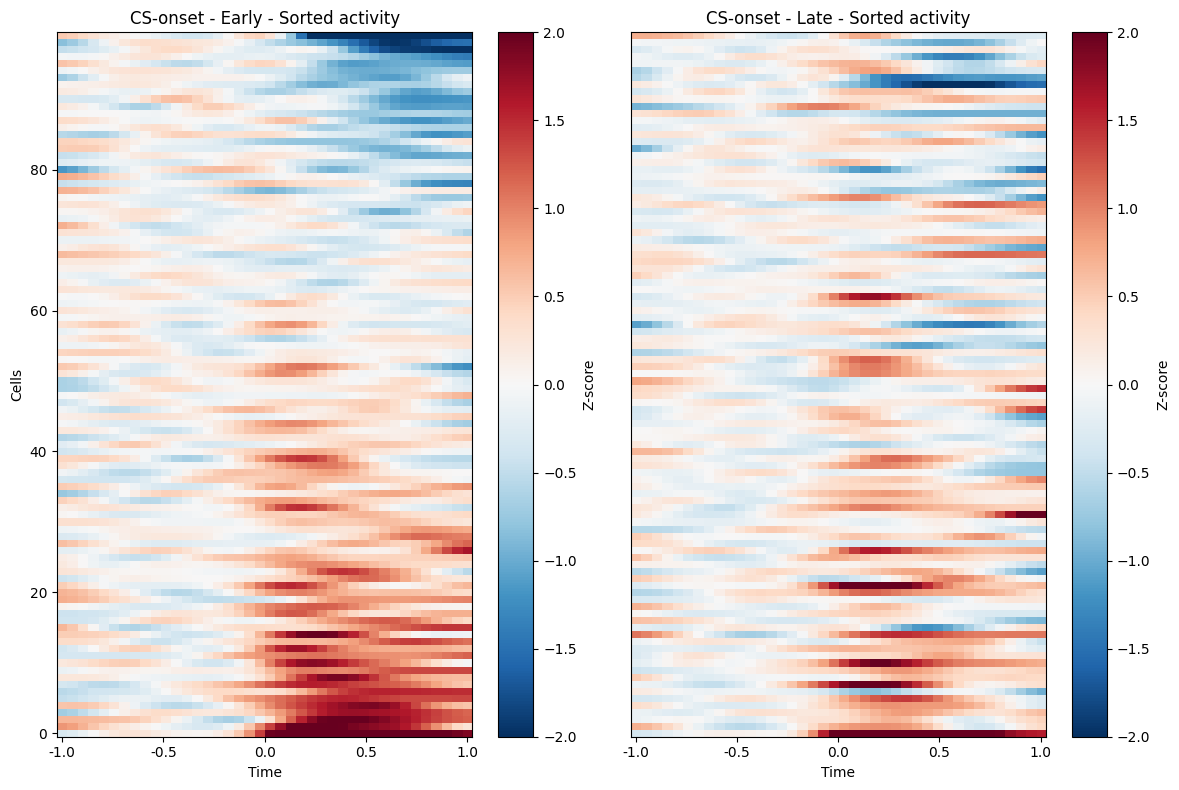

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d

# Paths to the CSV files
file_path1 = '/content/drive/My Drive/Colab Notebooks/Tugce/Extinction_CS/early ext 0 CS onset.csv'
file_path2 = '/content/drive/My Drive/Colab Notebooks/Tugce/Extinction_CS/late ext 0 CS onset.csv'

# Function to process the file
def process_file(file_path):
    # Load the data
    data = pd.read_csv(file_path, header=None)
    matrix = data.values

    # Logarithmic normalization
    epsilon = 1e-6 #  to avoid log of zero
    normalized_matrix_log = np.log1p(matrix + epsilon)

    # Split the matrix into initial and final halves
    n, m = normalized_matrix_log.shape
    mid_col = m // 2
    initial_half_log = normalized_matrix_log[:, :mid_col]

    # Identify rows with a standard deviation of zeros
    std_per_row = np.std(initial_half_log, axis=1)
    zero_std_indices = np.where(std_per_row == 0)[0]

    return matrix, zero_std_indices

# Process both files to find rows to exclude
matrix1, zero_std_indices1 = process_file(file_path1)
matrix2, zero_std_indices2 = process_file(file_path2)

# Combine unique indices from both files
combined_zero_std_indices = np.unique(np.concatenate((zero_std_indices1, zero_std_indices2)))

print(f"Excluded rows (indices) due to STD = 0 in file '{file_path1}': {zero_std_indices1.tolist()}")
print(f"Excluded rows (indices) due to STD = 0 in file '{file_path2}': {zero_std_indices2.tolist()}")
print(f"Combined excluded rows (indices): {combined_zero_std_indices.tolist()}")

# Exclude the combined identified rows from both matrices
matrix1_filtered = np.delete(matrix1, combined_zero_std_indices, axis=0)
matrix2_filtered = np.delete(matrix2, combined_zero_std_indices, axis=0)


# Normalize and smooth
def normalize_and_smooth(matrix):
    # Logarithmic normalization
    epsilon = 1e-6
    normalized_matrix_log = np.log1p(matrix + epsilon)

    # Split the matrix
    n, m = normalized_matrix_log.shape
    mid_col = m // 2
    initial_half_log = normalized_matrix_log[:, :mid_col]
    final_half_log = normalized_matrix_log[:, mid_col:]

    # Z-score normalization
    initial_half_normalized = (initial_half_log - np.mean(initial_half_log, axis=1, keepdims=True)) / (np.std(initial_half_log, axis=1, keepdims=True) + epsilon)
    final_half_normalized = (final_half_log - np.mean(initial_half_log, axis=1, keepdims=True)) / (np.std(initial_half_log, axis=1, keepdims=True) + epsilon)

    # Combine the normalized halves
    normalized_matrix = np.hstack((initial_half_normalized, final_half_normalized))

    # Apply smoothing with a Gaussian filter
    smoothed_matrix = gaussian_filter1d(normalized_matrix, sigma=3, axis=1)

    # Calculate the mean of the final half for sorting
    final_half_smoothed = smoothed_matrix[:, mid_col:]
    final_half_mean = np.mean(final_half_smoothed, axis=1)

    return smoothed_matrix, final_half_mean

# Normalize and smooth the matrices
matrix1_smoothed, final_half_mean1 = normalize_and_smooth(matrix1_filtered)
matrix2_smoothed, final_half_mean2 = normalize_and_smooth(matrix2_filtered)

# Sort the matrices
sorted_indices1 = np.argsort(final_half_mean1)[::-1]
sorted_indices2 = np.argsort(final_half_mean2)[::-1]

matrix1_sorted = matrix1_smoothed[sorted_indices1]
matrix2_sorted = matrix2_smoothed[sorted_indices1] # following the same cells - sorted 1


#Save
output_path_matrix1 = '/content/drive/My Drive/Colab Notebooks/Tugce/sorted_early ext 0 CS onset.csv'
output_path_matrix2 = '/content/drive/My Drive/Colab Notebooks/Tugce/sorted_late ext 0 CS onset.csv'
pd.DataFrame(matrix1_sorted).to_csv(output_path_matrix1, index=False, header=False)
pd.DataFrame(matrix2_sorted).to_csv(output_path_matrix2, index=False, header=False)

print(f"CSV files:")
print(f"- {output_path_matrix1}")
print(f"- {output_path_matrix2}")


# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# Plot the first heatmap
im1 = axes[0].imshow(matrix1_sorted, aspect='auto', cmap='RdBu_r', origin='lower', interpolation='none', vmin=-2, vmax=2)
axes[0].set_title('CS-onset - Early - Sorted activity')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Cells')
plt.colorbar(im1, ax=axes[0], label='Z-score')

num_timepoints = matrix1_sorted.shape[1]
x_ticks = np.linspace(0, num_timepoints - 1, 5)
x_labels = np.linspace(-1, 1, 5)
axes[0].set_xticks(x_ticks)
axes[0].set_xticklabels(x_labels.round(2))

# Plot the second heatmap
im2 = axes[1].imshow(matrix2_sorted, aspect='auto', cmap='RdBu_r', origin='lower', interpolation='none', vmin=-2, vmax=2)
axes[1].set_title('CS-onset - Late - Sorted activity')
axes[1].set_xlabel('Time')
axes[1].get_yaxis().set_visible(False)
plt.colorbar(im2, ax=axes[1], label='Z-score')

num_timepoints = matrix2_sorted.shape[1]
x_ticks = np.linspace(0, num_timepoints - 1, 5)
x_labels = np.linspace(-1, 1, 5)
axes[1].set_xticks(x_ticks)
axes[1].set_xticklabels(x_labels.round(2))

plt.tight_layout()
plt.show()

# Saving figure...
fig.savefig('/content/drive/My Drive/Colab Notebooks/Tugce/heatmap_CS.eps', format='eps', dpi=300)
fig.savefig('/content/drive/My Drive/Colab Notebooks/Tugce/heatmap_CS.png', format='png', dpi=300)


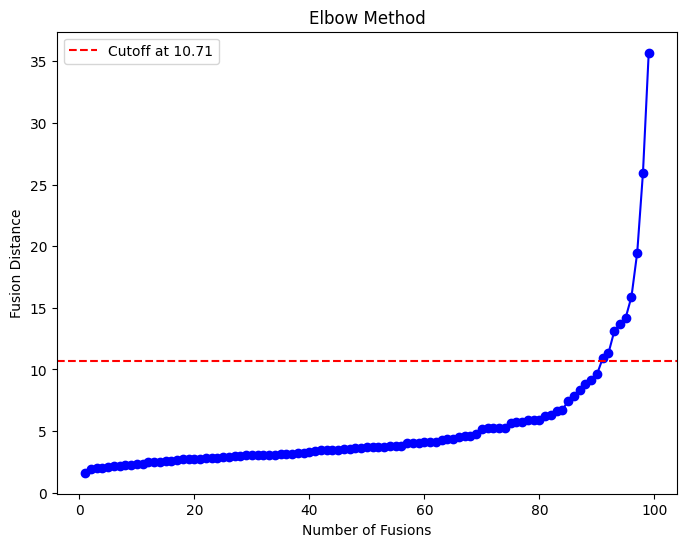

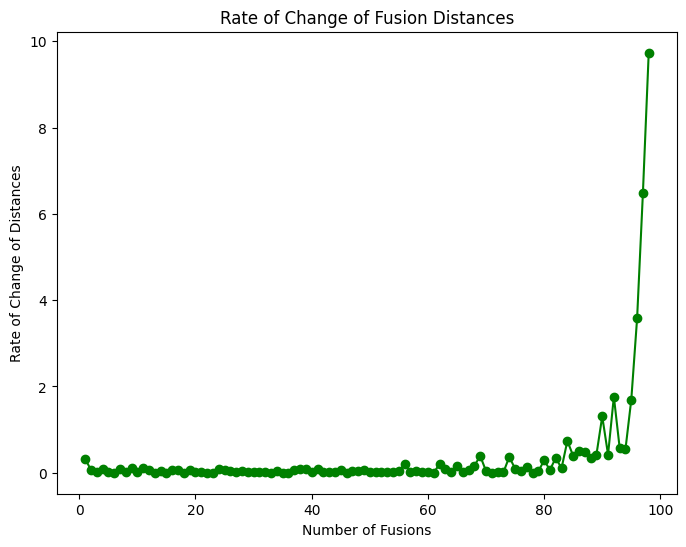

In [3]:
## Hierarchical Clustering Dendrogram
# Reference paper: "Thalamus sends information about arousal but not valence to the amygdala"

# Good link to learn: https://www.statisticshowto.com/hierarchical-clustering/
#                     https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html


from scipy.cluster.hierarchy import linkage

# Concatenate matrices
concatenated_matrix = np.hstack((matrix1_sorted, matrix2_sorted))

# Generate the hierarchical tree
Z = linkage(concatenated_matrix, method='ward', metric='euclidean')

# Obtain the fusion distances
distances = Z[:, 2]

# Plot the elbow method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(distances) + 1), distances, marker='o', color='b')

# Add a reference line
max_distance = np.max(distances)
cutoff = 0.30 * max_distance  # Define a cutoff as an example

plt.axhline(y=cutoff, color='r', linestyle='--', label=f'Cutoff at {cutoff:.2f}')
plt.title('Elbow Method')
plt.xlabel('Number of Fusions')
plt.ylabel('Fusion Distance')
plt.legend()

plt.show()

# Calculate the derivative of distances to observe the rate of change
derivative = np.diff(distances)

# Plot the derivative to help visualize the elbow point
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(derivative) + 1), derivative, marker='o', color='g')
plt.title('Rate of Change of Fusion Distances')
plt.xlabel('Number of Fusions')
plt.ylabel('Rate of Change of Distances')
plt.show()



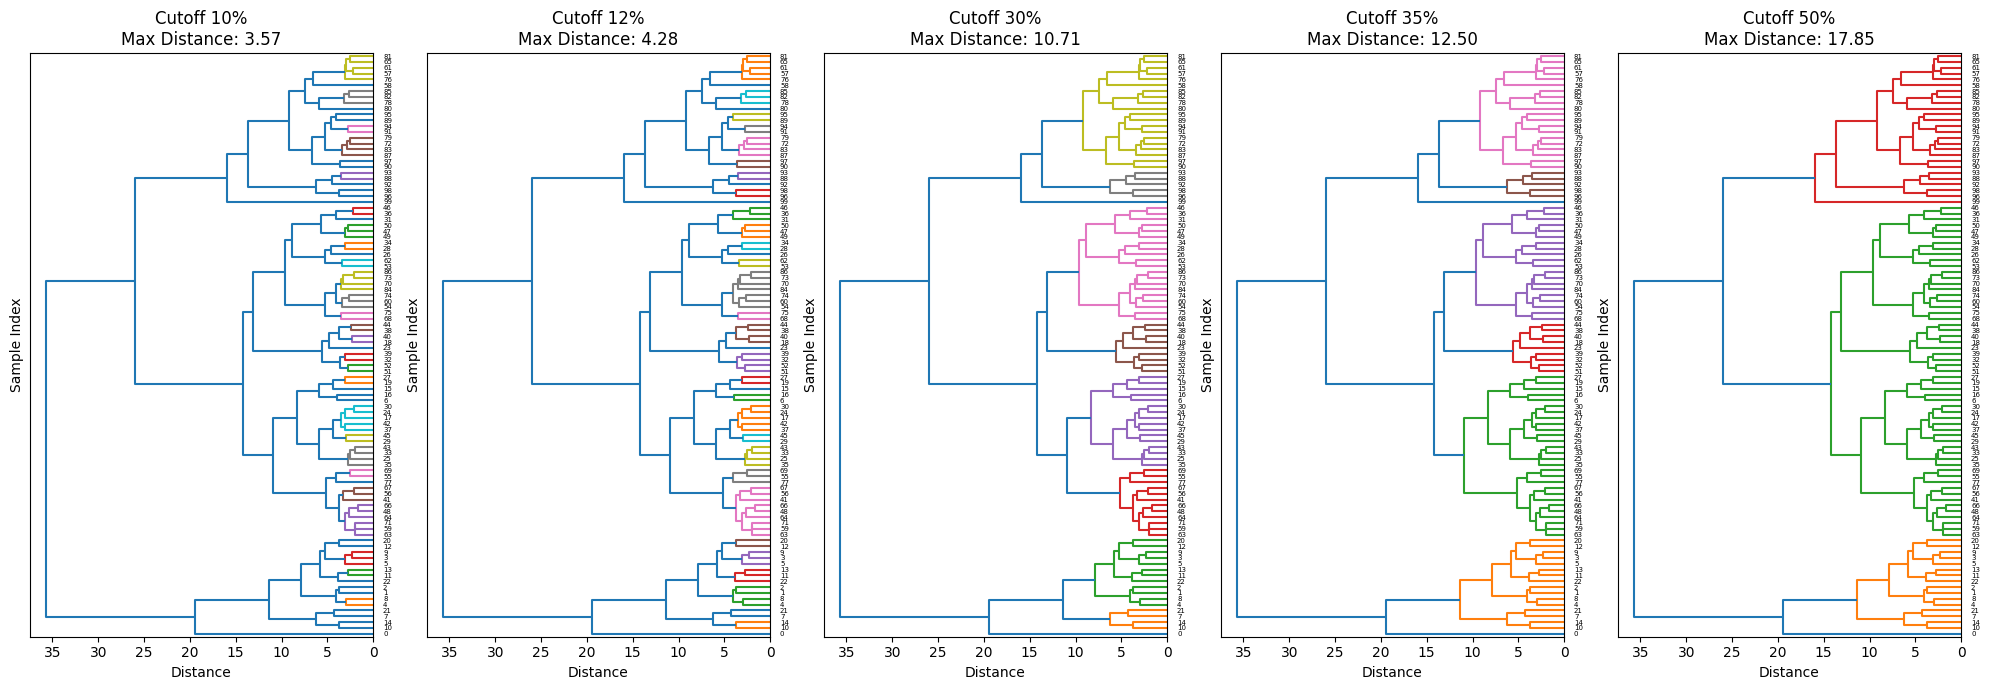

In [4]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist

# Percentages for testing the cutoff
percentages = [10, 12, 30, 35, 50]

fig, axes = plt.subplots(1, 5, figsize=(20, 7))

for i, percentage in enumerate(percentages):
    cutoff = (percentage / 100) * max_distance  # Calculate the cutoff value based on the percentage
    clusters = fcluster(Z, t=cutoff, criterion='distance')

    # Plotting the dendrogram with the specific cutoff
    dendrogram(Z, ax=axes[i], color_threshold=cutoff, orientation='left')

    axes[i].set_title(f"Cutoff {percentage}%\nMax Distance: {cutoff:.2f}")
    axes[i].set_xlabel("Distance")
    axes[i].set_ylabel("Sample Index")

plt.tight_layout()
plt.show()


Valid clusters greater than 3 cells: [1 2 3 5 6]


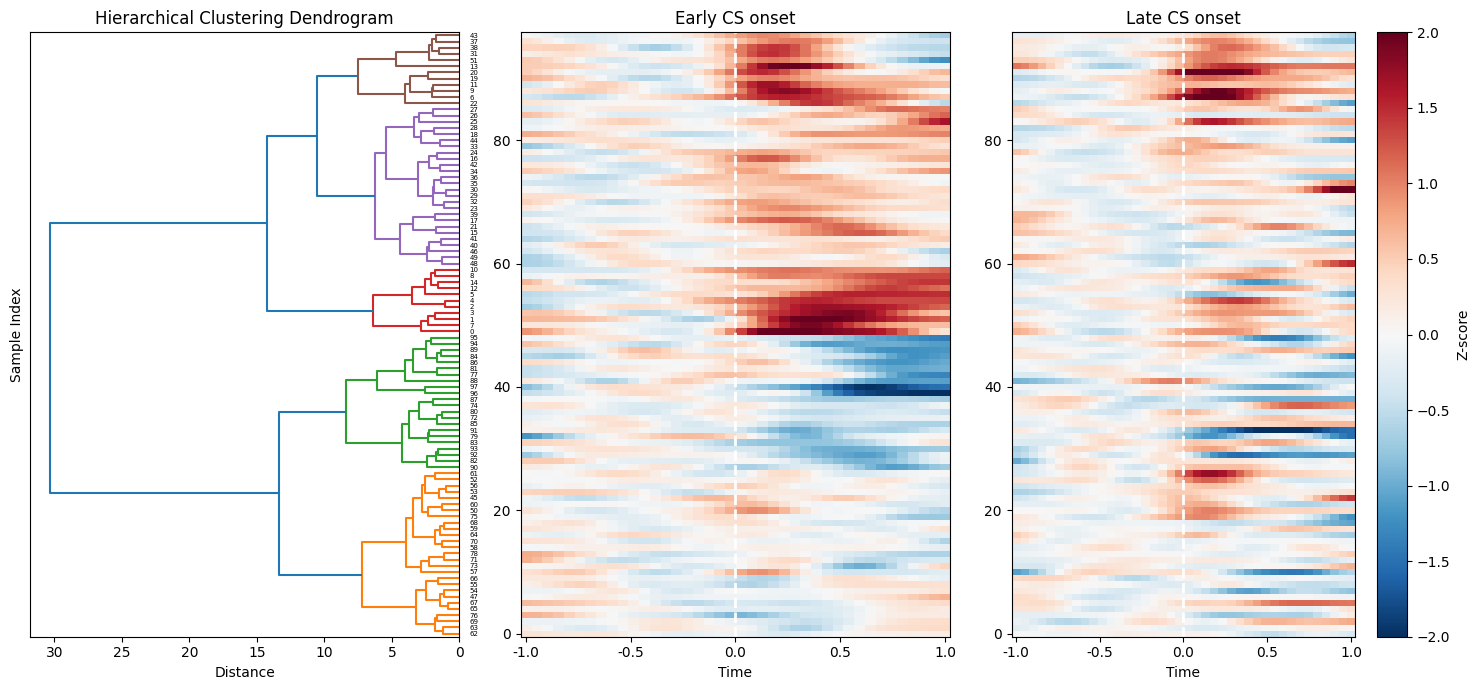

In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

c = concatenated_matrix.shape[1]
distance_matrix = pdist(concatenated_matrix[:, (c//2 - c//4):(c//2 + c//4 )], metric='euclidean')

# Ward method
# REF https://jbhender.github.io/Stats506/F18/GP/Group10.html
Z = linkage(distance_matrix, method='ward')

# Determine the cutoff value based on the maximum distance in the set
max_distance = np.max(Z[:, 2])
cutoff = .30 * max_distance

# Generate clusters based on the cutoff value
clusters = fcluster(Z, t=cutoff, criterion='distance')

# Identify valid clusters (with at least 3 cells)
unique_clusters, cluster_sizes = np.unique(clusters, return_counts=True)
valid_clusters = unique_clusters[cluster_sizes >= 3]
print(f"Valid clusters greater than 3 cells: {valid_clusters}")

# Filter the indices for valid clusters
valid_indices = np.isin(clusters, valid_clusters)

# Filter the matrix and clusters based on the valid indices
filtered_matrix = concatenated_matrix[valid_indices]
filtered_clusters = clusters[valid_indices]

# Recompute the linkage matrix on the filtered data to get a valid dendrogram
distance_matrix_filtered = pdist(filtered_matrix[:, (c//2 - c//4): (c//2 + c//4)], metric='euclidean')
Z_filtered = linkage(distance_matrix_filtered, method='ward')

# Get sorted indices based on dendrogram hierarchy for the filtered matrix
dendro = dendrogram(Z_filtered, no_plot=True)
sorted_indices = dendro['leaves']
sorted_filtered_matrix = filtered_matrix[sorted_indices]

# Split the filtered matrix into two parts based on CS onset
c = sorted_filtered_matrix.shape[1]
sorted_matrix_initiation = sorted_filtered_matrix[:, :c//2]  # First half of the data
sorted_matrix_termination = sorted_filtered_matrix[:, c//2:]  # Second half of the data

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))
dendrogram(Z_filtered, ax=ax1, color_threshold=cutoff, orientation='left')  # Rotate the dendrogram
ax1.set_title("Hierarchical Clustering Dendrogram")
ax1.set_xlabel("Distance")
ax1.set_ylabel("Sample Index")

cax = ax2.imshow(sorted_matrix_initiation, aspect='auto', cmap='RdBu_r', origin='lower', interpolation='none', vmin=-2, vmax=2)
ax2.set_title('Early CS onset')
ax2.set_xlabel('Time')

num_timepoints = sorted_matrix_initiation.shape[1]
x_ticks = np.linspace(0, num_timepoints - 1, 5)
x_labels = np.linspace(-1, 1, 5)
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_labels.round(2))
ax2.axvline(x=num_timepoints//2 - 0.5, color='white', linestyle='--', linewidth=2)

cax = ax3.imshow(sorted_matrix_termination, aspect='auto', cmap='RdBu_r', origin='lower', interpolation='none', vmin=-2, vmax=2)
ax3.set_title('Late CS onset')
ax3.set_xlabel('Time')

x_ticks = np.linspace(0, num_timepoints - 1, 5)
x_labels = np.linspace(-1, 1, 5)
ax3.set_xticks(x_ticks)
ax3.set_xticklabels(x_labels.round(2))
ax3.axvline(x=num_timepoints//2 - 0.5, color='white', linestyle='--', linewidth=2)

plt.colorbar(cax, ax=ax3, label='Z-score')

plt.tight_layout()

# Saving figure...
fig.savefig('/content/drive/My Drive/Colab Notebooks/Tugce/dendrogram_heatmap.eps', format='eps', dpi=300)
fig.savefig('/content/drive/My Drive/Colab Notebooks/Tugce/dendrogram_heatmap.png', format='png', dpi=300)

plt.show()


In [ ]:
# Save data *. CSV file
# could be more easy and not so redundant....

def save_matrix_with_blank_lines(matrix, clusters, filename, valid_clusters):
    """
    Saves the provided matrix with a blank line separating valid clusters.

    Parameters:
    - matrix: (sorted)
    - clusters: array of clusters corresponding to the sorted matrix
    - filename: name of the CSV file to be saved
    - valid_clusters: list of valid clusters
    """

    rows = []
    previous_cluster = clusters[0]

    for idx in range(len(clusters)):
        current_cluster = clusters[idx]

        if current_cluster in valid_clusters:
            # Add a blank line when switching clusters
            if idx > 0 and current_cluster != previous_cluster:
                rows.append([np.nan] * matrix.shape[1])

            # Add the current matrix row
            rows.append(matrix[idx])
            previous_cluster = current_cluster

    df = pd.DataFrame(rows)
    full_path = f"/content/drive/My Drive/Colab Notebooks/Tugce/{filename}"
    df.to_csv(full_path, index=False, header=False)
    print(f"File saved at: {full_path}")

freezing_initiation = sorted_matrix_initiation
freezing_termination = sorted_matrix_termination

valid_indices = np.isin(clusters, valid_clusters)
filtered_clusters = clusters[valid_indices]
sorted_filtered_clusters = filtered_clusters[sorted_indices]

unique_clusters, cluster_sizes = np.unique(sorted_filtered_clusters, return_counts=True)
valid_clusters = unique_clusters[cluster_sizes >= 3]

# Saving the CSV files
if len(valid_clusters) > 0:
    save_matrix_with_blank_lines(freezing_initiation, sorted_filtered_clusters, 'CS_early_onset.csv', valid_clusters)
    save_matrix_with_blank_lines(freezing_termination, sorted_filtered_clusters, 'CS_late_onset.csv', valid_clusters)
else:
    print("No valid clusters found.")


File saved at: /content/drive/My Drive/Colab Notebooks/Tugce/CS_early_onset.csv
File saved at: /content/drive/My Drive/Colab Notebooks/Tugce/CS_late_onset.csv
